# Flow-Matching Posterior Estimation (FMPE) and Neural Posterior Score Estimation (NPSE)

`sbi` also incorporates recent algorithms based on Flow Matching and Score Matching generative models, which are also referred to as Continuous Normalizing Flows (CNF) and Denoising Diffusion Probabilistic Models (DDPM), respectively.

At the highest level, you can conceptualize FMPE and NPSE as tackling the exact same problem as NPE, i.e., estimating the posterior from simulations, but replacing Normalizing Flows with different conditional density estimators. 

Flow Matching and Score Matching, as generative models, are also quite similar to Normalizing Flows, where a deep neural network parameterizes the transformation from a base distribution (e.g., Gaussian) to a more complex one that approximates the target density, but they differ in what this transformation looks like (more on that below). 

Beyond that, Flow Matching and Score Matching offer different benefits and drawbacks compared to Normalizing Flows, which make them better (or worse) choices for some problems. For examples, Score Matching (Diffusion Models) are known to be very flexible and can model high-dimensional distributions, but are comparatively slow during sampling.

In this tutorial, we take a brief look at the API for `FMPE` and `NPSE`, their pros and cons, as well as highlight some notable options.

For more information, see:

**Score Matching**:
- Hyvärinen, A. "Estimation of Non-Normalized Statistical Models by Score Matching." JMLR 2005.
- Song, Y., et al. "Score-Based Generative Modeling through Stochastic Differential Equations." ICLR 2021.
- Geffner, T., Papamakarios, G., and Mnih, A. "Score modeling for simulation-based inference." NeurIPS 2022 Workshop on Score-Based Methods. 2022.
- Sharrock, L., Simons, J., et al. "Sequential neural score estimation: Likelihood-free inference with conditional score based diffusion models." ICML 2024.

**Flow Matching**:
- Lipman, Y., et al. "Flow Matching for Generative Modeling." ICLR 2023
- Wildberger, J.B.,  Buchholz, S., et al. "Flow Matching for Scalable Simulation-Based Inference." NeurIPS 2023.

In [1]:
import torch

from sbi.analysis import pairplot
from sbi.inference import NPSE
from sbi.utils import BoxUniform

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


/mnt/lustre/work/macke/mgloeckler90/miniconda3/envs/sbi/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Example toy simulator
# Define the prior
num_dims = 3
num_sims = 5000
prior = BoxUniform(low=-torch.ones(num_dims), high=torch.ones(num_dims))

def simulator(theta):
    """Linear gaussian simulator."""
    return theta + 1.0 + torch.randn_like(theta) * 0.1

# Produce simulations
theta = prior.sample((num_sims,))
x = simulator(theta)

theta_o = torch.zeros(num_dims)
x_o = simulator(theta_o)

## FMPE

Flow-Matching Posterior Estimation (FMPE) is an approach to Simulation-Based Inference
(SBI) that leverages Flow Matching, a generative modeling technique where the
transformation from a simple base distribution (like a Gaussian) to the target
distribution is learned through matching the flow of probability densities.

### Key Concept:
- **Flow Matching**: The core idea is to model the probability flow between the base
  distribution and the target distribution by minimizing a discrepancy between their
  "flows" or "dynamics" in the latent space. This is typically done by training a neural
  network to parameterize a vector field that defines how samples should be moved or
  transformed in order to follow the target distribution.

### Step-by-Step Process:
1. **Base Distribution**: Start with a simple base distribution (e.g., Gaussian).
2. **Neural Network Parameterization**: Use a neural network to learn a vector field
   that describes the flow from the base distribution to the target distribution.
3. **Flow Matching Objective**: Optimize the neural network to minimize a loss function
   that captures the difference between the flow of the base distribution and the target
   distribution.
4. **Sampling**: Once trained, draw samples from the base distribution and apply the
   learned flow transformation to obtain samples from the approximate posterior
   distribution.

FMPE can be more efficient than traditional normalizing flows in some settings,
especially when the target distribution has complex structures or when high-dimensional
data is involved (see Dax et al., 2023, https://arxiv.org/abs/2305.17161 for an
example). However, compared to (discrete time) normalizing flows, flow matching is
usually slower at inference time because sampling and evaluation of the target
distribution requires solving the underlying ODE (compared to just doing a NN forward
pass for normalizing flows). 

In the next cell, we'll show how to use FMPE using the `sbi` package.



In [3]:
from sbi.inference import FMPE
from sbi.neural_nets import posterior_flow_nn

# the quick way
trainer = FMPE(prior)
trainer.append_simulations(theta, x).train()
posterior = trainer.build_posterior()

 Neural network successfully converged after 467 epochs.

/mnt/lustre/work/macke/mgloeckler90/sbi/sbi/inference/trainers/base.py:569: FutureWarning: The following arguments are deprecated and will be removed in a future version: mcmc_method, vi_method. Please use `posterior_parameters` instead. Refer to this guide for details:
https://sbi.readthedocs.io/en/latest/how_to_guide/19_posterior_parameters.html#
  self._raise_deprecation_warning(deprecated_params, **kwargs)


In [4]:
# Set up a custom vector field neural network
net_builder = posterior_flow_nn(
    model="mlp",
    num_layers=3,
    hidden_features=24,
    # embedding_net=CNNEmbedding  # e.g., for image data.
)
trainer = FMPE(prior, vf_estimator=net_builder)
trainer.append_simulations(theta, x).train(training_batch_size=200, learning_rate=5e-4)
posterior = trainer.build_posterior()
posterior_samples = posterior.sample((10000,), x_o)

 Neural network successfully converged after 229 epochs.

Drawing 10000 posterior samples for 1 observations: 10099it [00:00, 17021.84it/s]                          


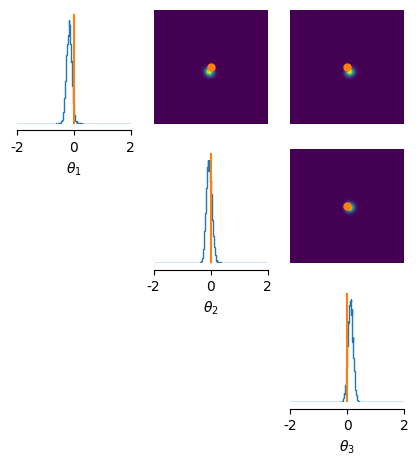

In [5]:
# plot posterior samples
fig, ax = pairplot(
    posterior_samples, limits=[[-2, 2], [-2, 2], [-2, 2]], figsize=(5, 5),
    labels=[r"$\theta_1$", r"$\theta_2$", r"$\theta_3$"],
    points=theta_o # add ground truth thetas
)

---

## NPSE

NPSE approximates the posterior distribution by learning its score function, i.e., gradient of the log-density, using the denoising score matching loss. The class of generative models is referred to as score-based generative models, with close links to diffusion models.

- Score-based generative models have been shown to scale well to very high dimensions (e.g., high-resolutions images), which is particularly useful when the parameter space (and hence, the target posterior) is high-dimensional.
- On the other hand, sampling can be slower as it involves solving many steps of the stochastic differential equation for reversing the diffusion process.

Note that only the single-round version of NPSE is implemented currently.

For more details on score-based generative models, see [Song et al., 2020](https://arxiv.org/abs/2011.13456) (in particular, Figure 1 and 2).

In [6]:
# Instantiate NPSE and append simulations
inference = NPSE(prior=prior, sde_type="ve")
inference.append_simulations(theta, x)

Note the argument `sde_type`, which defines whether the forward diffusion process has a noising schedule that is Variance Exploding (`ve`, i.e., [SMLD](https://proceedings.neurips.cc/paper/2019/hash/3001ef257407d5a371a96dcd947c7d93-Abstract.html?ref=https://githubhelp.com)), Variance Preserving (`vp`, i.e., [DDPM](https://proceedings.neurips.cc/paper/2020/hash/4c5bcfec8584af0d967f1ab10179ca4b-Abstract.html)), or sub-Variance Preserving (`subvp`) in the limit.

In [7]:
# Train the score estimator
score_estimator = inference.train()

 Neural network successfully converged after 136 epochs.

In [8]:
# Build the posterior using the trained score estimator, and sample
posterior = inference.build_posterior(score_estimator)
posterior_samples = posterior.sample((10000,), x=x_o)

Drawing 10000 posterior samples: 100%|██████████| 499/499 [00:10<00:00, 46.73it/s]0<?, ?it/s]
Drawing 10000 posterior samples for 1 observations: 100%|██████████| 10000/10000 [00:10<00:00, 936.14it/s]


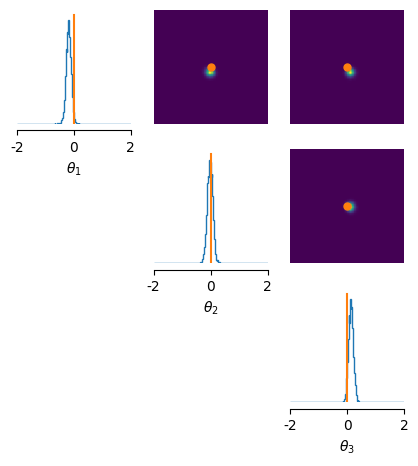

In [9]:
# plot posterior samples
fig, ax = pairplot(
    posterior_samples, limits=[[-2, 2], [-2, 2], [-2, 2]], figsize=(5, 5),
    labels=[r"$\theta_1$", r"$\theta_2$", r"$\theta_3$"],
    points=theta_o # add ground truth thetas
)

## Vector field nets

While NPE is architecturally limited to conditional density networks, both FMPE and NPSE solve a **regression problem** targeting a specific *vector field* of choice (e.g., marginal scores or transport velocities). This is advantageous because it allows us to use any "off-the-shelf" neural network to address our problem, in contrast to NPE, which is typically restricted to normalizing flows.

However, their performance can be highly dependent on the suitability of the chosen neural network for the task at hand. For instance, diffusion models achieve state-of-the-art generative performance on images only when paired with a carefully designed U-Net–like architecture.  

For both FMPE and NPSE, we provide a selection of neural networks tailored to the task:  
- `mlp` and `ada_mlp` (MLP with adaptive layer norm for conditioning) — MLP variants that inject time information at each layer, as is common in diffusion architectures.  
- `transformer` and `transformer_cross_attn` — scalable diffusion transformers (e.g., as in [https://arxiv.org/abs/2212.09748](https://arxiv.org/abs/2212.09748)). The cross-attention variant supports arbitrary sequence lengths for conditioning.  

For certain data types, such as image-like inputs, it may still be beneficial to use a more specialized architecture.


In [10]:
net_builder = posterior_flow_nn(
    model="transformer",
    num_layers=2,
    num_heads=2,
    hidden_features=64,
)

# Transformers do benefit from GPU acceleration way more than e.g. NPE.
trainer = FMPE(prior.to("gpu"), vf_estimator=net_builder, device="cuda")  # Or NPE
estimator = trainer.append_simulations(theta, x).train(training_batch_size=200, learning_rate=5e-4)

/mnt/lustre/work/macke/mgloeckler90/sbi/sbi/inference/trainers/vfpe/base_vf_inference.py:176: UserWarning: Data x has device 'cpu'. Moving x to the data_device 'cuda'. Training will proceed on device 'cuda'.
  theta, x = validate_theta_and_x(
/mnt/lustre/work/macke/mgloeckler90/sbi/sbi/inference/trainers/vfpe/base_vf_inference.py:176: UserWarning: Parameters theta has device 'cpu'. Moving theta to the data_device 'cuda'. Training will proceed on device 'cuda'.
  theta, x = validate_theta_and_x(


 Neural network successfully converged after 241 epochs.

Drawing 10000 posterior samples: 100%|██████████| 499/499 [00:01<00:00, 312.45it/s]<?, ?it/s]
Drawing 10000 posterior samples for 1 observations: 100%|██████████| 10000/10000 [00:01<00:00, 6157.09it/s]


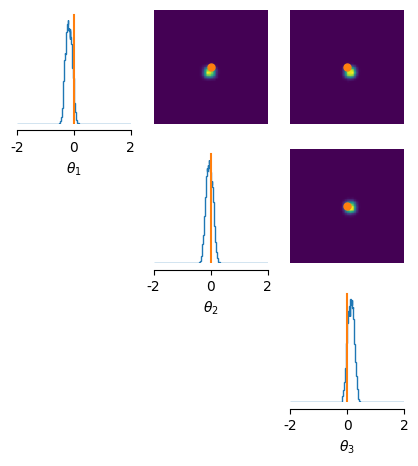

In [11]:
# Build the posterior using the trained score estimator, and sample
posterior = inference.build_posterior(estimator)
posterior_samples = posterior.sample((10000,), x=x_o)

# plot posterior samples
fig, ax = pairplot(
    posterior_samples.to("cpu"), limits=[[-2, 2], [-2, 2], [-2, 2]], figsize=(5, 5),
    labels=[r"$\theta_1$", r"$\theta_2$", r"$\theta_3$"],
    points=theta_o # add ground truth thetas
)

A custom neural net can be an arbirary `torch.nn.Module` that follows the abstract `VectorFieldNet` protocol. You can use any of the shelf neural network implemented in pytorch and e.g. "wrap" it to satisfy these constraints.

In [12]:
from sbi.utils.vector_field_utils import VectorFieldNet

?VectorFieldNet.forward

Signature:
VectorFieldNet.forward(
    self,
    theta: torch.Tensor,
    x: torch.Tensor,
    t: torch.Tensor,
) -> torch.Tensor
Docstring:
Forward pass to compute the vector field.

Args:
    theta: Parameters
    x: Conditioning information
    t: Time parameter (scalar or batched)

Returns:
    Vector field evaluation at the provided points
File:      /mnt/lustre/work/macke/mgloeckler90/sbi/sbi/utils/vector_field_utils.py
Type:      function

In [13]:
class CustomNetExample(VectorFieldNet): # This can also just be torch.nn.Module
    def __init__(self):
        super().__init__()
        self.in_layer1 = torch.nn.Conv1d(1,512, kernel_size=3)
        self.in_layer2 = torch.nn.Conv1d(1,512, kernel_size=3)
        self.time_layer = torch.nn.Linear(1,512)
        self.out_layer = torch.nn.Linear(512,3)

    def forward(self, theta, x, t):
        # Requires 3 arguments for input (i.e. theta), condition (i.e. x) and "time" (a scalar)

        # Whatever weird things you want to do, you can do here.
        h1 = self.in_layer1(x[...,None,:]).mean(-1)
        h2 = self.in_layer2(theta[...,None,:]).mean(-1)
        t = self.time_layer(t[...,None])
        h = torch.relu(h1 + h2 + t)
        out = self.out_layer(h)

        # Output dimension must exaclty match "theta.shape"
        return out

net_base = CustomNetExample()
# This will still add some of `sbi` standard "preconditioning" for
# diffusion/fmpe as well as automatic z-scoring transforms.
# If you do want this you can also simple write your own builder.
net_builder = posterior_flow_nn(
    model=net_base,
)

trainer = FMPE(prior.to("cpu"), vf_estimator=net_builder)
estimator = trainer.append_simulations(theta, x).train(training_batch_size=200, learning_rate=5e-4)

 Neural network successfully converged after 470 epochs.

Drawing 10000 posterior samples: 100%|██████████| 499/499 [00:16<00:00, 30.90it/s]0<?, ?it/s]
Drawing 10000 posterior samples for 1 observations: 100%|██████████| 10000/10000 [00:16<00:00, 619.10it/s]


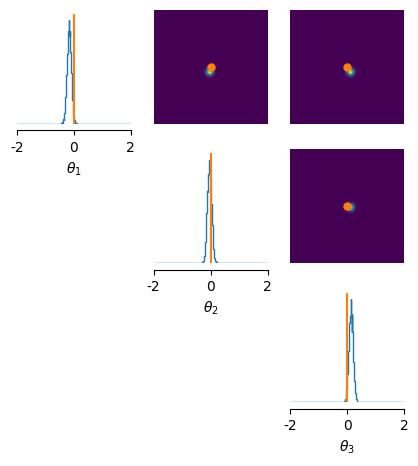

In [14]:
# Build the posterior using the trained score estimator, and sample
posterior = inference.build_posterior(estimator)
posterior_samples = posterior.sample((10000,), x=x_o)

# plot posterior samples
fig, ax = pairplot(
    posterior_samples.to("cpu"), limits=[[-2, 2], [-2, 2], [-2, 2]], figsize=(5, 5),
    labels=[r"$\theta_1$", r"$\theta_2$", r"$\theta_3$"],
    points=theta_o # add ground truth thetas
)